In [1]:
import sys
import re, string
import pandas as pd

from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


%matplotlib inline

In [2]:
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

### Funcs

In [3]:
def iou(y_real, y_pred):
    return (y_real & y_pred).sum() / (y_real | y_pred).sum()

In [4]:
re_tok = re.compile('([%s])' % re.escape(string.punctuation+"“”¨«»®´·º½¾¿¡§£₤‘’"))
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

tokenize("I am the right guy for you!")

['I', 'am', 'the', 'right', 'guy', 'for', 'you', '!']

### Read and Explore Train Data

#### 1. Read:

In [5]:
train = pd.read_csv("data/train.csv")

In [6]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\r\n\r\nCongratulations from me as well, use ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
train['comment_text'][0]

"Explanation\r\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [8]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [9]:
# replace Nones by "unknown"
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)

#### 2. Describe labels fracs and stats:

In [10]:
for col in train.columns[2:]:
    print(col, ":", train[col].sum()/train.shape[0])

toxic : 0.09584448302009764
severe_toxic : 0.009995550569965721
obscene : 0.052948217407925
threat : 0.002995531769557125
insult : 0.04936360616904074
identity_hate : 0.00880485802558109


In [11]:
# add none label and describe labels stats:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.iloc[:, 2:].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 3. Analyze Comments lengths

In [12]:
lens = train.comment_text.str.len() # number of chars
lens.mean(), lens.std(), lens.max()

(396.5939613087591, 594.3878690070298, 5000)

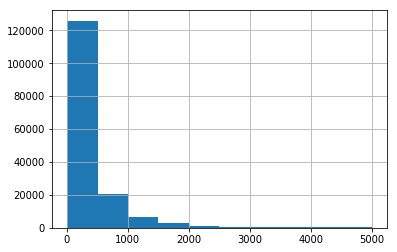

In [13]:
lens.hist()

### Tokenization

### Simple Binary Classification

In [14]:
X = train.comment_text
y = train.toxic

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

#### 0. Tokenization

In [16]:
# vect = CountVectorizer(ngram_range=(1,2))

In [17]:
n = X_train.shape[0]
vect = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, max_df=0.9, strip_accents="unicode", 
                       use_idf=1, smooth_idf=1, sublinear_tf=1)
trn_term_doc = vect.fit_transform(X_train)
tst_term_doc = vect.transform(X_test)

In [18]:
trn_term_doc, tst_term_doc

(<106912x311016 sparse matrix of type '<class 'numpy.float64'>'
 	with 11734323 stored elements in Compressed Sparse Row format>,
 <52659x311016 sparse matrix of type '<class 'numpy.float64'>'
 	with 5640683 stored elements in Compressed Sparse Row format>)

#### 1. Simple SVM

In [ ]:
clf = SVC()
clf.fit(trn_term_doc, y_train)

In [ ]:
y_tst_pred = clf.predict(tst_term_doc)
y_tst_proba = clf.predict_proba(tst_term_doc)

#### 2. NB-SVM

In [26]:
def get_p_terms_given_label(x, labels, desired_label, soft_coef=1):
    n_occurances_for_term = x[labels==desired_label].sum(0)
    n_occurances_of_desired_label = (labels==desired_label).sum()
    return (n_occurances_for_term + soft_coef) / (n_occurances_of_desired_label + soft_coef)

In [30]:
class NB_SVM_binary():
    def __init__(self, model=LogisticRegression(C=4., dual=True), ):
        self.model = model
    def fit(self, x_train, y_train):
        pr_terms_given_1 = get_p_terms_given_label(x_train, y_train, 1)
        pr_terms_given_0 = get_p_terms_given_label(x_train, y_train, 0)
        self.r_ = np.log(pr_terms_given_1 / pr_terms_given_0)
        x_nb = x.multiply(self.r_)
        self.model.fit(self, x_nb, y_train)
        return self
    def predict_proba(self, x):
        return self.model.predict_proba(x.multiply(self.r_))[:, 1]

In [31]:
clf = NB_SVM_binary()

In [32]:
clf.fit(trn_term_doc, y_train)

IndexError: invalid index